## Rotary Positional Embeddings

https://nn.labml.ai/transformers/rope/index.html

https://blog.eleuther.ai/rotary-embeddings/

### Transfromers Again

In [1]:
import torch
from torch import nn

In [2]:
class Config:    
    vocab_size = 4026
    dim = 552
    n_heads = 12
    head_size = dim // n_heads
    n_layers = 12
    n_kv_heads = 3
    seq_len = 1024
    multiple_of = 256
    
config = Config()

In [3]:

class RoPE(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.cos_mthetas = None
        self.sin_mthetas = None
        self.__set_thetas()
        
    def __set_thetas(self):
        """This sets the parameters of the rope as per the formula
        Θ = {θi = 10000−2(i−1)/d, i ∈ [1, 2, ..., d/2]}
        """
        assert self.config.head_size % 2 == 0, f"Head size:{self.config.head_size} shouls be even number"
        self.d = self.config.head_size
        self.m = self.config.seq_len
        
        i_s = torch.tensor(range(1,self.d//2+1))
        i_s = torch.cat([i_s,i_s], axis=-1)
        m_s = torch.tensor(range(self.m)).unsqueeze(axis=-1)
        
        thetas = 10000 ** (-2*(i_s-1)/self.d)
        self.cos_mthetas = torch.cos(m_s * thetas).to("cuda")
        self.sin_mthetas = torch.sin(m_s * thetas).to("cuda")
        
    def forward(self, x):
        """ assumes x in the format of """
        d  = x.shape[-1]
        print(f"shapes in RoPE in oredr x, : {x.shape, self.cos_mthetas.shape},d:{d}")
        assert d == self.d
        
        x = self.cos_mthetas * x + self.sin_mthetas * torch.cat([-1 * x[:,:,:,self.d//2:],x[:,:,:,:self.d//2]], axis=-1)
        return x
        
    
    

In [4]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.n_rep = self.config.n_heads // self.config.n_kv_heads
        self.query = nn.Linear(self.config.dim, self.config.n_heads * self.config.head_size, bias=False)
        self.key = nn.Linear(self.config.dim, self.config.n_kv_heads * self.config.head_size, bias=False)
        self.value = nn.Linear(self.config.dim, self.config.n_kv_heads * self.config.head_size, bias=False)
        self.rope = RoPE(self.config)
        self.proj = nn.Linear(self.config.n_heads * self.config.head_size, self.config.n_heads * self.config.head_size, bias=False)
        
    def forward(self, x, y=None):
        b,t,d = x.shape
        q = self.query(x).view(b,t,self.config.n_heads,self.config.head_size)
        k = self.key(x).view(b,t,self.config.n_kv_heads,self.config.head_size)
        v = self.value(x).view(b,t,self.config.n_kv_heads,self.config.head_size)
        print(f"Shapes of Q, K, V: {q.shape, k.shape, v.shape}")
        
        ## Add rotary embeddings        
        q = self.rope(q.permute(0,2,1,3)).permute(0,2,1,3)
        k = self.rope(k.permute(0,2,1,3)).permute(0,2,1,3)
        
        ##GQA 
        k = repeat_kv(k,self.n_rep)
        v = repeat_kv(v,self.n_rep)
        print(f"Shapes of Q, K, V: {q.shape, k.shape, v.shape}")
        # make heads into a batch dimension
        q = q.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        ## Flash attention
        x = nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True)
        
         # restore time as batch dimension and concat heads
        x = x.transpose(1, 2).contiguous().view(b, t, -1)

        # final projection into the residual stream
        x = self.proj(x)
        
        return x
        

        
        
        
    

In [5]:
class FeedForwordNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config        
        hidden_units = int(self.config.dim * 4 * 2/3) ##
        hidden_units = int(hidden_units - (hidden_units % self.config.multiple_of) + self.config.multiple_of)
        
        self.w = nn.Linear(self.config.dim, hidden_units)
        self.v = nn.Linear(self.config.dim, hidden_units)
        self.w2 = nn.Linear(hidden_units, self.config.dim)
        self.silu = nn.SiLU()
        
    def forward(self, x):
        out = self.w2(self.silu(self.w(x)) * self.v(x))
        return out

In [6]:
class RMSNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.eps = 1e-5
        self.dim = config.dim
        self.weight = nn.Parameter(torch.ones(self.dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

In [7]:
class AttentionLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.mha = MultiHeadAttention(self.config)
        self.ffn = FeedForwordNetwork(self.config)
        self.anorm = RMSNorm(config)
        self.fnorm = RMSNorm(config)
        
    def forward(self,x):
        x = x + self.mha(self.anorm(x))
        x = x + self.ffn(self.fnorm(x))
        return x
        

In [8]:
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding_layer = nn.Embedding(self.config.vocab_size, self.config.dim)
        self.layers = nn.Sequential(*[AttentionLayer(self.config) for _ in range(self.config.n_layers)])
        self.hnorm = RMSNorm(config)
        self.clf_head = nn.Linear(self.config.dim, self.config.vocab_size)
    
    def forward(self, x, y=None):
        x = self.embedding_layer(x)
        x = self.layers(x)
        x = self.hnorm(x)
        x = self.clf_head(x)
        return x
        
            

In [211]:
multiple_of = 256
hidden_dim = 4 * 512
print(hidden_dim)
hidden_dim = int(2 * hidden_dim / 3)
print(hidden_dim)
hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)
print(hidden_dim)

2048
1365
1536


## Testing 

In [178]:
### Attention

In [239]:
516 / 12

43.0

In [253]:
46 * 12

552

In [254]:
552 / 12

46.0

In [259]:
attention = Attention(config)

In [260]:
x = torch.ones(size=(16, config.seq_len, config.dim)) * 1.0
out = attention(x)

Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))


In [261]:
x.shape, out.shape

(torch.Size([16, 1024, 552]), torch.Size([16, 1024, 552]))

In [266]:
ff = FeedForword(config)
ffout = ff(out)

In [267]:
x.shape, out.shape, ffout.shape

(torch.Size([16, 1024, 552]),
 torch.Size([16, 1024, 552]),
 torch.Size([16, 1024, 552]))

In [197]:
x = x.view(16, config.seq_len, config.n_heads, config.head_size)
x.shape

torch.Size([16, 1024, 8, 64])

## AttentionLayer Test

In [283]:
x = torch.ones(size=(16, config.seq_len, config.dim)) * 1.0
layer = AttentionLayer(config)
out = layer(x)
print(x.shape, out.shape)

Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))
torch.Size([16, 1024, 552]) torch.Size([16, 1024, 552])


### Model Test

In [9]:
x = torch.ones(size=(16, config.seq_len), dtype=torch.int32).to("cuda")
model = Model(config).to("cuda")
out = model(x)
print(x.shape, out.shape)

Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), torch.Size([1024, 46])),d:46
shapes in RoPE in oredr x, : (torch.Size([16, 3, 1024, 46]), torch.Size([1024, 46])),d:46
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 12, 46]))
Shapes of Q, K, V: (torch.Size([16, 1024, 12, 46]), torch.Size([16, 1024, 3, 46]), torch.Size([16, 1024, 3, 46]))
shapes in RoPE in oredr x, : (torch.Size([16, 12, 1024, 46]), to

OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 5.16 GiB is allocated by PyTorch, and 131.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n#######Total parameter of the model: {total_params * 1e-6}")


#######Total parameter of the model: 44.17053


In [199]:
xq = torch.rand(size=(16, config.seq_len, config.n_heads, config.head_size))
xq_r, xq_i = xq.float().reshape(xq.shape[:-1] + (-1, 2)).unbind(-1)

In [201]:
xq.shape[:-1] + (-1, 2)

torch.Size([16, 1024, 8, -1, 2])

In [202]:
xq.float().reshape(xq.shape[:-1] + (-1, 2)).shape

torch.Size([16, 1024, 8, 32, 2])

In [167]:
rope = RoPE(config)

In [168]:
x = torch.ones(size=(16, config.seq_len, config.dim)) * 1.0

In [169]:
x.shape, x.view(16, config.seq_len, config.n_heads, config.head_size).shape

(torch.Size([16, 1024, 512]), torch.Size([16, 1024, 8, 64]))

In [170]:
x = x.view(16, config.seq_len, config.n_heads, config.head_size)

In [171]:
x = x.permute(0, 2, 1, 3)

In [172]:
x.shape

torch.Size([16, 8, 1024, 64])

In [173]:
x_rope = rope(x)

In [174]:
x.shape, x_rope.shape

(torch.Size([16, 8, 1024, 64]), torch.Size([16, 8, 1024, 64]))

In [73]:
x[0,0,:], x_rope[0,0,:]

(tensor([1., 1.]), tensor([1., 1.]))

In [75]:
x_rope[0,:,:].shape

torch.Size([1024, 2])

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

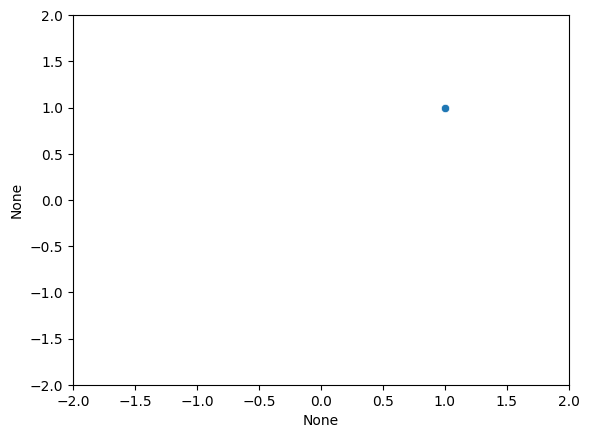

In [95]:
sns.scatterplot(x=x_rope[0,:1,0], y=x_rope[0,:1,1])
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.show()

In [97]:
x_rope[0,:,:].shape

torch.Size([1024, 2])

In [139]:
data = [[(0.0, 0.0, i),tuple(point +[i,])] for i,point in enumerate(x_rope[0,:,:].numpy().tolist())]

In [140]:
data = [row for sub in data for row in sub]
data[:5]

[(0.0, 0.0, 0),
 (1.0, 1.0, 0),
 (0.0, 0.0, 1),
 (-0.30116862058639526, 1.3817732334136963, 1),
 (0.0, 0.0, 2)]

In [141]:
df = pd.DataFrame(data=data, columns=["x1","x2","t"])
df.head()

,x1,x2,t
0,0.000000,0.000000,0
1,1.000000,1.000000,0
2,0.000000,0.000000,1
3,-0.301169,1.381773,1
4,0.000000,0.000000,2


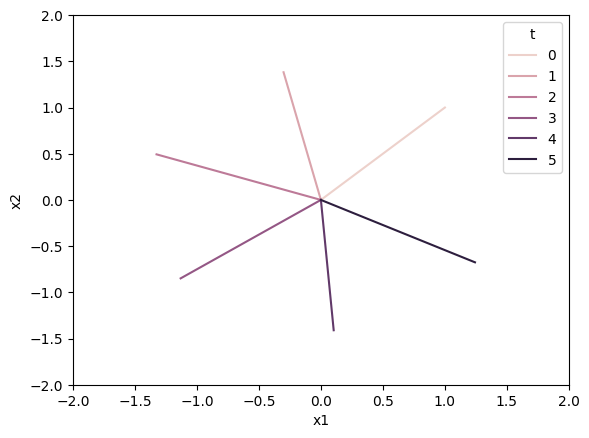

In [142]:
sns.lineplot(x="x1", y="x2",hue="t",data=df)
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.show()

In [108]:
tuple( [0.31338733434677124, -1.3790533542633057])

(0.31338733434677124, -1.3790533542633057)

In [99]:
import pandas as pd
pd.DataFrame(x_rope[0,:,:], columns=['x1','x2'])

,x1,x2
0,1.000000,1.000000
1,-0.301169,1.381773
2,-1.325444,0.493151
3,-1.131112,-0.848872
4,0.103159,-1.410446
...,...,...
1019,-0.469731,1.333924
1020,-1.376255,0.325457
1021,-1.017456,-0.982233
1022,0.276787,-1.386863


### Revision

In [68]:
## Some parameters
vocab_size = 4096
context_length = 1024
tokenizers_path = "saved_artifacts/tokenizers"
subset_size = 2000
batch_size = 4
dim = 512
n_heads = 8
n_layers = 8
head_size = dim // n_heads

In [4]:
## Data preparation

from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader
import sentencepiece as spm
import os
from functools import partial

tokenizer_model_path = os.path.join(tokenizers_path,f"tok_{vocab_size}.model")
tokenizer = spm.SentencePieceProcessor(model_file=tokenizer_model_path)    

In [19]:
def process_rows_func(examples, tokenizer, context_length):     
    idx = 0 
    inputs, targets = [],[]


    tokenized_examples = tokenizer.encode(examples["text"], add_bos=True)
    merged_text = [token for example in tokenized_examples for token in example]

    while idx < len(merged_text)-context_length:
        chunk = merged_text[idx:idx+context_length+1]
        inputs.append(chunk[:-1])
        targets.append(chunk[1:])
        idx += context_length
    return {"inputs":inputs, "targets":targets}

In [36]:
dataset = load_dataset("roneneldan/TinyStories")
dataset = dataset["train"]
dataset = dataset.select(range(subset_size))
            
dataset = dataset.map(
    process_rows_func,
    fn_kwargs={'tokenizer':tokenizer, 'context_length':context_length},
    batched=True,
    num_proc=4,
    remove_columns=dataset.column_names    
)
dataset.set_format(type='torch', columns=dataset.column_names)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [37]:
## Print dataste example
print(dataset["inputs"][0][:10])
print(dataset["targets"][0][:10])

tensor([   1,  422,  361, 3968,  261,  399,  447,  502,  349,  592])
tensor([ 422,  361, 3968,  261,  399,  447,  502,  349,  592,  261])


In [40]:
### Modeling part
import torch
from torch import nn

In [61]:
query = nn.Linear(dim, dim, bias=False)
key = nn.Linear(dim, dim, bias=False)
value = nn.Linear(dim, dim, bias=False)

In [62]:
token_embeddings = nn.Embedding(vocab_size, dim)
position_embeddings = nn.Embedding(context_length, dim)

In [63]:
x = token_embeddings(dataset["inputs"][0:4])
positions = torch.tensor(range(x.shape[-2]))
x = x + position_embeddings(positions)


In [70]:
q = query(x)
k = key(x)
v = value(x)

In [72]:
q.shape, k.shape, v.shape

(torch.Size([4, 1024, 512]),
 torch.Size([4, 1024, 512]),
 torch.Size([4, 1024, 512]))

In [73]:
b, s, e = q.shape
q = q.view(b, s, n_heads, head_size)
k = k.view(b, s, n_heads, head_size)
v = v.view(b, s, n_heads, head_size)

In [74]:
q.shape, k.shape, v.shape

(torch.Size([4, 1024, 8, 64]),
 torch.Size([4, 1024, 8, 64]),
 torch.Size([4, 1024, 8, 64]))

In [75]:
## permute shapes

In [80]:
q = q.permute(0,2,1,3)
k = k.permute(0,2,1,3)
v = v.permute(0,2,1,3)

In [81]:
q.shape, k.shape, v.shape

(torch.Size([4, 8, 1024, 64]),
 torch.Size([4, 8, 1024, 64]),
 torch.Size([4, 8, 1024, 64]))

In [83]:
### Self attention
dk = k.shape[-1]

(q @ k.transpose(-2,-1)) / torch.sqrt(dk) * v


TypeError: sqrt(): argument 'input' (position 1) must be Tensor, not int

In [82]:
k.transpose(-2,-1).shape

torch.Size([4, 8, 64, 1024])